In [0]:
!pip install keras-bert
!pip install keras-xlnet
!pip install tokenization
!pip install bert
!pip install keras-lr-finder
!pip install bert-tensorflow
!pip install numpy==1.16.2

In [1]:
%tensorflow_version 1.14
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import cv2
from os import listdir
from sklearn.metrics import accuracy_score
from PIL import Image

import tensorflow as tf
import tensorflow_hub as hub  #pip install tensorflow_hub
import os
import tokenization
from tensorflow.keras import backend as K
#from tokenization import FullTokenizer
# from keras import backend as K
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

from keras_lr_finder import LRFinder
from pprint import pprint
tf.logging.set_verbosity(tf.logging.ERROR)
from random import choice
import gc
from bert import tokenization

no_of_gpu = 1

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Colab Notebooks/data")

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Params for bert model and tokenization
#bert_path = "https://tfhub.dev/google/bert_chinese_L-12_H-768_A-12/1"
bert_path = "bert_chinese/"

In [0]:
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [0]:
np.random.seed(42)
tf.set_random_seed(42)

In [0]:
df = pd.read_csv("train.csv")

In [0]:
df = df.drop_duplicates(
    subset=['text', 'piclist', 'userGender', 'userFollowCount', 'userFansCount', 'userWeiboCount', 'userLocation',
            'userDescription']).reset_index()
data_size = len(df)

df['label'].value_counts()

0    17042
1    17010
Name: label, dtype: int64

In [0]:
data = df
data['textb'] = data['userLocation'].fillna('没有地址')
data['userDescription'] = "@@" + data['userDescription'].fillna('没有描述')
data['category'] = "@@" + data['category'].fillna('没有分类')
data['piclist'] = data['piclist'].fillna('')
data['pic_size'] = data['piclist'].apply(lambda x: str(len(x.split("\t"))) if x else '0')
data['pic_size'] = "@@图片个数" + data['pic_size']
data['textb'] = data['textb'] + data['category'] + data['pic_size']

for col_name in [['userFollowCount', '用户关注数'], ['userFansCount', '粉丝数'], ['userWeiboCount', '发布微博数']]:
    print(col_name)
    col = col_name[0]
    name = col_name[1]
    data[col] = data[col].fillna(0).map(int)
    name = "@@" + name
    data[col] = name + data[col].map(str)
    data['textb'] = data['textb'] + data[col]

data['textb'] = data['textb'] + data['userDescription']

data[['textb']].head()

['userFollowCount', '用户关注数']
['userFansCount', '粉丝数']
['userWeiboCount', '发布微博数']


,textb
0,北京朝阳区@@文体娱乐@@图片个数0@@用户关注数1728@@粉丝数748@@发布微博数30...
1,云南楚雄@@社会生活@@图片个数1@@用户关注数423@@粉丝数112@@发布微博数792@...
2,没有地址@@社会生活@@图片个数1@@用户关注数0@@粉丝数0@@发布微博数0@@没有描述
3,北京东城区@@社会生活@@图片个数1@@用户关注数1668@@粉丝数7470000@@发布微...
4,江苏盐城@@社会生活@@图片个数0@@用户关注数267@@粉丝数61@@发布微博数1098@...


In [0]:
list_images_dir = listdir('data/images/')
num = 0
print(data['piclist'][9])

for i in data['piclist'][9].split("	"):
    plt.imshow(Image.open("data/images/" + str(i)))

FileNotFoundError: ignored

In [0]:
broken_pic = ['data/images/8bf6bc37d0a977f7e5424dc6ba58cc30.jpg',
 'data/images/2654c75fd0771c8868d19dc5c8d8bd0e.jpg',
 'data/images/68f465018884a65c1a1e7112bd43cd5a.jpg',
 'data/images/90f61d893579340b62fa835b60bd8d3d.jpg',
 'data/images/1f5202565a59f057936872495f8b42c6.jpg',
 'data/images/60e7f40411a56d1d182eb28a63b6689d.jpg',
 'data/images/86d84cb1d26e2af443a171fe4d6bad56.jpg',
 'data/images/df7f947d83a8d673b951f3dfd792000e.jpg',
 'data/images/8831a5da197f04a78383145719243f59.jpg',
 'data/images/3e2704ce900278f94f7195ad2b69fa1e.jpg',
 'data/images/91016adaaba8f38360ca6402e4454070.jpg',
 'data/images/be8902bf59dcc611e6806d6f501b58b5.jpg',
 'data/images/7df40dab3d3cf65af329641c06523343.jpg',
 'data/images/651ed4e8dc3e6550ad3dc7c1b2a81862.jpg',
 'data/images/f80d5515d4caa4631a2e57f07b21908c.jpg',
 'data/images/bbe0af60586653eb536494e5e6cddbed.jpg',
 'data/images/f8dd8b98eba5ffb76eaec9ea823d6632.jpg',
 'data/images/99bceb0f305537eae98b35ec6dd551bb.jpg',
 'data/images/912e4c8b65a4ed55f8f8d3c8e19e9583.jpg',
 'data/images/58f00271e9b039a033a89c4f8fbc4dbf.jpg',
 'data/images/355fd1d32bb83ed1595e18259d76e1a3.jpg',
 'data/images/81937b140359a35198d44b045cce3339.jpg',
 'data/images/c3617bd03cc014f4f64207b6347203cf.jpg',
 'data/images/3dcc8031a292f17a1df4997e4204ad31.jpg',
 'data/images/3ca7a6b182d3bce4ecaa9878b6ec9172.jpg',
 'data/images/4b3698fa04ed26064c7feb3729d3605a.jpg',
 'data/images/e5c1acc6ca4677f6957562dea00a46e1.jpg',
 'data/images/958324ac129e0a39427019ea23306e1f.jpg',
 'data/images/2024c1ebb9b4279d07c05c1534003938.jpg',
 'data/images/39e9728530e6d2fedcadfcec154a2f5c.jpg',
 'data/images/2024c1ebb9b4279d07c05c1534003938.jpg',
 'data/images/711d3c7a7a677a59e81114231f8415dd.jpg',
 'data/images/27a17a5132f958f970d0e4a230eb3b57.jpg',
 'data/images/213a3e86a3aaa538998ae564b6739113.jpg',
 'data/images/6bbd638534a1797b66c49654476afd61.jpg',
 'data/images/8943a5aa71a8960c5f96eef92706e0ab.jpg',
 'data/images/a5e6cc73755ea90a4a8b0c9a745fe1c5.jpg',
 'data/images/d7d917eb6c4302155fba7be1eb4f66ea.jpg',
 'data/images/ac57cec354d50d931a4bab2f246e462a.jpg',
 'data/images/6cce4bb5ad74e141e175465b114343b2.jpg',
 'data/images/213a3e86a3aaa538998ae564b6739113.jpg',
 'data/images/2a7aadf023019df8f660bf8ddad01d7d.jpg',
 'data/images/e972ebd97382d52ec3de79bca2c7918d.jpg',
 'data/images/06bac8cf4514020ffe1d1153ab62b61c.jpg',
 'data/images/1bcd13f173cc3e734d31c74bef2c1625.jpg',
 'data/images/132dafb3daa3827cdcd1ea38879ac48a.jpg',
 'data/images/849eb890650fbd6b4ddbadc1028a5783.jpg']

def index_to_delete(list_):
    list_images_dir = listdir('data/images/')
    index = []
    for i,v in enumerate(list_):
        image_list = v.split('	')
        if str(v) == '':
            index.append(i)
        if image_list[0] not in list_images_dir:
            index.append(i)
        if ".gif" in v:
            index.append(i)
        for j in broken_pic:
            if str('data/images/' +v) in j:
                index.append(i)
    return list(set(index))

In [0]:
data_delete_index = index_to_delete(data['piclist'])
len(data_delete_index)

14850

In [0]:
data_image = np.array(data['piclist'])
data_text = np.array(data['text'])
data_label = np.array(data['label'])

In [0]:
data_image = np.delete(data_image, data_delete_index)
data_text = np.delete(data_text, data_delete_index)
data_label = np.delete(data_label, data_delete_index)

In [0]:
for i in range(len(data_image)):
    image_list = data_image[i].split('	')
    if len(image_list)> 1:
        data_image[i] = image_list[0]


In [0]:
shuffle_index= np.arange(len(data_image))
np.random.shuffle(shuffle_index)
data_image = data_image[shuffle_index]
data_text = data_text[shuffle_index]
data_label = data_label[shuffle_index]

shuffle_index

array([ 3234,  9459, 14700, ...,  5390,   860, 15795])

In [0]:
np.save('data_image.npy',data_image)
np.save('data_text.npy',data_text)
np.save('data_label.npy',data_label)

In [0]:
data_image = np.load('data_image_1.npy')
data_text = np.load('data_text_1.npy')
data_label = np.load('data_label_1.npy')
data_description = np.load('data_description_1.npy')

In [0]:
len(data_image), len(data_text), len(data_label), len(data_description)

(19209, 19209, 19209, 19209)

In [0]:
length = int(len(data_image) * 0.8)
train_images = data_image[:length]
train_text = data_text[:length]
trainY = data_label[:length]
train_description = data_description[:length]
test_images = data_image[length:]
test_text = data_text[length:]
testY = data_label[length:]
test_description = data_description[length:]

In [0]:
len(train_images),len(test_images), len(trainY), len(testY)

(15367, 3842, 15367, 3842)

In [0]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s) for s in lines])

max len 1994


(array([2234., 2955., 8252., 1149.,  322.,  136.,   66.,   49.,   34.,
          12.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 498]),
 <a list of 10 Patch objects>)

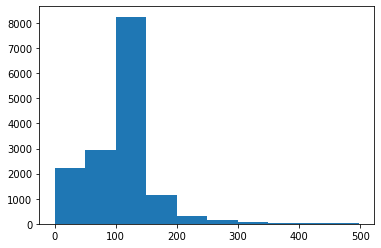

In [0]:
print(f'max len {max_length(train_text)}')
plt.hist([len(s) for s in train_text],bins=[0,50,100,150,200,250,300,350,400,450,498])

In [0]:
max_seq_length = 512

In [0]:
train_text = np.load('train_text.npy')
trainY = np.load('train_label.npy')
test_text = np.load('test_text.npy')
testY = np.load('test_label.npy')

visual_train = np.load('visual_features_train.npy')
visual_test = np.load('visual_features_test.npy')

# Text part

In [8]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, trainY 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, testY
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


# Image Part

In [0]:
length = 224
width = 224
channels = 3

In [0]:
error = []
def read_and_process_image(list_of_images):
    X = [] 
    for image in tqdm_notebook(list_of_images):
#         print(image)
        a = cv2.imread(image, cv2.IMREAD_COLOR)
        try:
            X.append(cv2.resize(a, (length,width), interpolation=cv2.INTER_CUBIC))  
        except:
            print(a)
            error.append(image)
    return X

In [0]:
train_images = ['data/images/'+i for i in train_images]
test_images = ['data/images/'+i for i in test_images]

In [0]:
train_imagesX = read_and_process_image(train_images)
test_imagesX = read_and_process_image(test_images)

D:\soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [0]:
error

[]

In [0]:
np.save('train_imagesX.npy', train_imagesX)
np.save('test_imagesX.npy', test_imagesX)

In [0]:
train_imagesX = np.load('train_imagesX.npy')
test_imagesX = np.load('test_imagesX.npy')

In [0]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )

        trainable_vars = self.bert.variables

        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]

        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
            
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
def initialize_vars(sess):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) #command to run codeon multiple gpu
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [0]:
def get_news_model(params):
    
    K.clear_session()
    
    with tf.device('/gpu:0'):
        bert_base = BertLayer()
        bert_base.trainable= params['bert_trainable']

        in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
        in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
        in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
        bert_inputs = [in_id, in_mask, in_segment]
        bert_output = bert_base(bert_inputs)

        if params['text_no_hidden_layer']>0:
            for i in range(params['text_no_hidden_layer']):
                bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
                bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

        text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

        #image model
        conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=True, input_shape=(224,224,3))
        conv_base.trainable=False

        input_image = tf.keras.layers.Input(shape=(224,224,3))
        base_output = conv_base(input_image)
        flat = tf.keras.layers.Flatten()(base_output)

        if params['vis_no_hidden_layer']>0:
            for i in range(params['vis_no_hidden_layer']):
                flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
                flat = tf.keras.layers.Dropout(params['dropout'])(flat)

        visual_repr = tf.keras.layers.Dense(params['repr_size'],activation='relu')(flat)


        #classifier
        combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
        com_drop=tf.keras.layers.Dropout(params['dropout'])(combine_repr)

        if params['final_no_hidden_layer']>0:
            for i in range(params['final_no_hidden_layer']):
                com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
                com_drop=tf.keras.layers.Dropout(params['dropout'])(com_drop)

        prediction = tf.keras.layers.Dense(1,activation='sigmoid')(com_drop)

        model = tf.keras.models.Model(inputs=[in_id,in_mask,in_segment,input_image], outputs=prediction)

    #model = tf.keras.utils.multi_gpu_model(model,gpus=no_of_gpu)
    
#     if params['optimizer'] == 'adam':
#         opt = tf.keras.optimizers.Adam(lr=0.0005)
#     else:
#         opt = tf.keras.optimizers.RMSprop(lr=0.00005)
        
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    initialize_vars(sess)
    
    
    return model

In [0]:
def get_news_model(params):
    
    K.clear_session()
    
    with tf.device('/gpu:0'):
        bert_base = BertLayer()
        bert_base.trainable= params['bert_trainable']

        in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
        in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
        in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
        bert_inputs = [in_id, in_mask, in_segment]
        bert_output = bert_base(bert_inputs)

        if params['text_no_hidden_layer']>0:
            for i in range(params['text_no_hidden_layer']):
                bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
                bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

        text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

        #image model
        input_image = tf.keras.layers.Input(shape=(1152))
        flat = tf.keras.layers.Dense(768, activation='relu')(input_image)

        visual_repr = tf.keras.layers.Dense(params['repr_size'],activation='relu')(flat)


        #classifier
        combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
        com_drop=tf.keras.layers.Dropout(params['dropout'])(combine_repr)

        if params['final_no_hidden_layer']>0:
            for i in range(params['final_no_hidden_layer']):
                com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
                com_drop=tf.keras.layers.Dropout(params['dropout'])(com_drop)

        prediction = tf.keras.layers.Dense(1,activation='sigmoid')(com_drop)

        model = tf.keras.models.Model(inputs=[in_id,in_mask,in_segment,input_image], outputs=prediction)

    #model = tf.keras.utils.multi_gpu_model(model,gpus=no_of_gpu)
    
#     if params['optimizer'] == 'adam':
#         opt = tf.keras.optimizers.Adam(lr=0.0005)
#     else:
#         opt = tf.keras.optimizers.RMSprop(lr=0.00005)
        
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    initialize_vars(sess)
    
    
    return model

In [0]:
params_data = {
    'bert_trainable' :True,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':128,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':tf.keras.optimizers.Adam
}

In [13]:
model=get_news_model(params_data)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [0]:
out = model.fit([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    shuffle=True,
                    validation_split=0.33)

Train on 10291 samples, validate on 5070 samples
Epoch 1/10
10291/10291 [==============================] - 192s 19ms/sample - loss: 0.3979 - acc: 0.8064 - val_loss: 0.2043 - val_acc: 0.9034
Epoch 2/10
10291/10291 [==============================] - 181s 18ms/sample - loss: 0.2397 - acc: 0.8987 - val_loss: 0.1802 - val_acc: 0.9369
Epoch 3/10
10291/10291 [==============================] - 181s 18ms/sample - loss: 0.1809 - acc: 0.9357 - val_loss: 0.1188 - val_acc: 0.9588
Epoch 4/10
10291/10291 [==============================] - 181s 18ms/sample - loss: 0.1330 - acc: 0.9530 - val_loss: 0.1604 - val_acc: 0.9292
Epoch 5/10
10291/10291 [==============================] - 181s 18ms/sample - loss: 0.1114 - acc: 0.9630 - val_loss: 0.1631 - val_acc: 0.9473
Epoch 6/10
10291/10291 [==============================] - 181s 18ms/sample - loss: 0.0831 - acc: 0.9703 - val_loss: 0.1294 - val_acc: 0.9550
Epoch 7/10
10291/10291 [==============================] - 181s 18ms/sample - loss: 0.0837 - acc: 0.9695 -

In [14]:
out = model.fit([train_input_ids, train_input_masks, train_segment_ids,visual_train], trainY,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    shuffle=True,
                    validation_split=0.33)

Train on 10288 samples, validate on 5068 samples
Epoch 1/10
10288/10288 [==============================] - 396s 39ms/sample - loss: 0.4903 - acc: 0.7954 - val_loss: 0.2179 - val_acc: 0.9181
Epoch 2/10
10288/10288 [==============================] - 392s 38ms/sample - loss: 0.2098 - acc: 0.9181 - val_loss: 0.1592 - val_acc: 0.9349
Epoch 3/10
10288/10288 [==============================] - 392s 38ms/sample - loss: 0.1496 - acc: 0.9431 - val_loss: 0.1310 - val_acc: 0.9453
Epoch 4/10
10288/10288 [==============================] - 392s 38ms/sample - loss: 0.1077 - acc: 0.9617 - val_loss: 0.1341 - val_acc: 0.9481
Epoch 5/10
10288/10288 [==============================] - 392s 38ms/sample - loss: 0.1262 - acc: 0.9603 - val_loss: 0.1848 - val_acc: 0.9183
Epoch 6/10
10288/10288 [==============================] - 392s 38ms/sample - loss: 0.0792 - acc: 0.9741 - val_loss: 0.1388 - val_acc: 0.9601
Epoch 7/10
10288/10288 [==============================] - 392s 38ms/sample - loss: 0.0673 - acc: 0.9792 -

In [0]:
model.save('MMFFND-Spotfake-Finetune.h5')

In [0]:
#model.load('MMFFND-Spotfake-Finetune.h5')

In [0]:
test_predict = model.predict([test_input_ids, test_input_masks, test_segment_ids,visual_test])
test_predict = [1 if i>=0.5 else 0 for i in test_predict]

In [0]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [0]:
print(f'Accuracy == {accuracy_score(testY,test_predict)}')
print(f'F1 == {f1_score(testY,test_predict,average=None)}')
print(f'Precision == {precision_score(testY,test_predict,average=None)}')
print(f'Recall == {recall_score(testY,test_predict,average=None)}')

Accuracy == 0.9708409268419682
F1 == [0.9707113  0.97096941]
Precision == [0.95966908 0.98217095]
Recall == [0.98201058 0.9600205 ]


In [17]:
print(f'Accuracy == {accuracy_score(testY,test_predict)}')
print(f'F1 == {f1_score(testY,test_predict,average=None)}')
print(f'Precision == {precision_score(testY,test_predict,average=None)}')
print(f'Recall == {recall_score(testY,test_predict,average=None)}')

Accuracy == 0.9585829643136233
F1 == [0.95554934 0.96122897]
Precision == [0.9804934 0.9403626]
Recall == [0.93184297 0.98304239]


In [0]:
fault = []
for i in range(len(test_predict)):
    if test_predict[i] != testY[i]:
        fault.append(i)

In [0]:
len(fault)

112

In [0]:
testY[1]

array([0])

In [0]:
for i in fault:
    print(test_text[i] + "  predict: " + str(test_predict[i]) + ", truth: " + str(int(testY[i])) + "\n")

【袖珍小猴走红网络，高智慧宠物“不好养”】昨天，一只宠物猴的照片风靡网络。据了解，这种猴名为“石猴”宠物猴，必须在合法商贩处购买。但石猴并不易养，有网友表示：石猴性格太过活泼，“很皮，模仿力很高，有的时候会自己打开煤气阀门，拿着打火机玩，很危险！”敬请关注@全球震惊百分百  predict: 0, truth: 1

【男子和女友ML时JJ自燃烧焦了】2人均是河南商丘当地一所学校的学生，女孩今年18。女孩透露爱爱前男友喜欢喝白酒，这次也是，正要到高潮的时候她突然觉得下体越来越热，而男友面部表情复杂说不出话，才发现有点不对。医生证实，男子JJ基本报废，女孩下体已被灼伤，目前起火原因不明。From陕西新闻网  predict: 0, truth: 1

方舟子是个什么玩意儿？  predict: 1, truth: 0

7月16日早上七点半左右在雁塔区西安外事学院东赢园雅筑西南坐出租车到陕西省人民医院急救中心门前下车，由于本人粗心大意将自己的紫色钱包落在出租车上，钱包内没多少钱，主要有自己好多证件，证件姓名晁娜，证件尾号7624望那位好心人看见能归还。谢谢@漂西安@漂西安@西安直播@西安城事儿@西安直播  predict: 1, truth: 0

别说我没介绍好工作给你们  predict: 0, truth: 1

【多地PM指数频临爆表南京连续污染8天】从1月5日开始，南京空气质量连续污染，昨天已是第八天。昨晚帝都网友@米娜33发微博说：今儿北京毒气爆表，我家水龙头放出来的水成这样儿了，一盆毒死你！#我家水龙头会喷鹤顶红#。网友评论：帝都的亲还是把自来水给戒了吧！！！  predict: 0, truth: 1

【不必看的N类微信】1.是中国人就转！2.赶紧告诉家人！3.原来几十年都吃错了。4.中央已经震惊！5.少妇受不住了。6.扫码即领取。7.转发十个人，功德无量。8.看人家啥啥人怎样教育孩子。9.珍藏版国军抗战英名录。10.我军在南海击沉美国航母。11.国人愤怒了。12.看完就哭了……|黄山·排云...  predict: 1, truth: 0

//分享网易新闻:《泸州中学生坠亡事件续:警方与家属对话录音曝光》泸州中学生坠亡事件续:警方与家属对话录音曝光@网易新闻客户端#网易新闻#  predict: 0, truth: 1

宁波妇幼母携四月儿坠楼亡

In [0]:
params_data_2 = {
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':400,
    'dropout':0.3,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':64,
    'optimizer':tf.keras.optimizers.Adam
}

model_2=get_news_model(params_data_2)

In [0]:
out_2 = model_2.fit([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY))

Train on 15361 samples, validate on 3841 samples
Epoch 1/100
15361/15361 [==============================] - 264s 17ms/sample - loss: 0.5217 - acc: 0.7498 - val_loss: 0.3729 - val_acc: 0.8258
Epoch 2/100
15361/15361 [==============================] - 183s 12ms/sample - loss: 0.3567 - acc: 0.8448 - val_loss: 0.3004 - val_acc: 0.8753
Epoch 3/100
15361/15361 [==============================] - 183s 12ms/sample - loss: 0.3333 - acc: 0.8559 - val_loss: 0.3874 - val_acc: 0.8110
Epoch 4/100
15361/15361 [==============================] - 181s 12ms/sample - loss: 0.3087 - acc: 0.8667 - val_loss: 0.2647 - val_acc: 0.8883
Epoch 5/100
15361/15361 [==============================] - 180s 12ms/sample - loss: 0.2954 - acc: 0.8757 - val_loss: 0.2656 - val_acc: 0.8907
Epoch 6/100
15361/15361 [==============================] - 181s 12ms/sample - loss: 0.2874 - acc: 0.8777 - val_loss: 0.3116 - val_acc: 0.8589
Epoch 7/100
15361/15361 [==============================] - 181s 12ms/sample - loss: 0.2763 - acc: 0

15361/15361 [==============================] - 181s 12ms/sample - loss: 0.2061 - acc: 0.9145 - val_loss: 0.2020 - val_acc: 0.9183
Epoch 59/100
15361/15361 [==============================] - 181s 12ms/sample - loss: 0.2098 - acc: 0.9102 - val_loss: 0.2268 - val_acc: 0.8964
Epoch 60/100
15361/15361 [==============================] - 181s 12ms/sample - loss: 0.2100 - acc: 0.9097 - val_loss: 0.2025 - val_acc: 0.9130
Epoch 61/100
15361/15361 [==============================] - 181s 12ms/sample - loss: 0.2171 - acc: 0.9056 - val_loss: 0.1976 - val_acc: 0.9183
Epoch 62/100
15361/15361 [==============================] - 181s 12ms/sample - loss: 0.2171 - acc: 0.9070 - val_loss: 0.2127 - val_acc: 0.9055
Epoch 63/100
15361/15361 [==============================] - 181s 12ms/sample - loss: 0.2356 - acc: 0.8943 - val_loss: 0.2045 - val_acc: 0.9175
Epoch 64/100
15361/15361 [==============================] - 181s 12ms/sample - loss: 0.2126 - acc: 0.9072 - val_loss: 0.1992 - val_acc: 0.9159
Epoch 65/100

In [0]:
test_predict = model_2.predict([test_input_ids, test_input_masks, test_segment_ids,test_imagesX])
test_predict = [1 if i>=0.5 else 0 for i in test_predict]

print(f'Accuracy == {accuracy_score(testY,test_predict)}')
print(f'F1 == {f1_score(testY,test_predict,average=None)}')
print(f'Precision == {precision_score(testY,test_predict,average=None)}')
print(f'Recall == {recall_score(testY,test_predict,average=None)}')

Accuracy == 0.9135641759958344
F1 == [0.91216931 0.91491543]
Precision == [0.91216931 0.91491543]
Recall == [0.91216931 0.91491543]
